# Proposal for Government Zonal Hospitals - Mumbai (code)

Let's import all the libraries required

In [1]:
# Import requests and beautiful soup for web scrapping
import requests
from bs4 import BeautifulSoup

#Import numpy and pandas for dataframe processing
import pandas as pd
import numpy as np

# import Intertools for flattening a list of lists
import itertools

# import packages to find latitude and longitude
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    geopy-1.19.0               |             py_0          53 KB  conda-forge
    ca-certificates-2019.3.9   |       hecc5488_0         146 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0         conda-forge
    geopy:           1.19.0-py_0       conda-forge

The following packages will be UPDATED:

   

In [2]:
# import libraries for kmean clustering 
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

#Import libraries for maps
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import numpy as np


#Import folium
!conda install -c conda-forge folium=0.5.0 --yes
import folium
print('Folium installed and imported!')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.3.1               |             py_0          25 KB  conda-forge
    altair-2.2.2               |           py35_1         462 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         560 KB

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge


branca-0.3.1         | 25 KB     | #############################

To get the list of all areas in the city of mumbai, use https://worldpostalcode.com/india/maharashtra/mumbai/. To extract all the pincodes and areas in mumbai use "Beautiful Soup". First extract into a dictionary and then convert the dictionary into a dataframe.

In [3]:
# get the url of the webpage that u need to extraxt data from 
url = 'https://worldpostalcode.com/india/maharashtra/mumbai/'

# use requests and BeautifulSoup to get the data
raw_data = requests.get(url).text

soup = BeautifulSoup(raw_data, 'lxml')

# extract place names to place_temp and pincode values to code_temp
place_temp = soup.find_all('div',class_='place')
code_temp = soup.find_all('div',class_='code')

# creating a dictionary for the data extracted
raw_data_dict ={}

# create key for the dict
i = 0

#add the pincode and name pf the place to dictionary
for p,c in zip(place_temp,code_temp):
    place = p.text
    try :
        code1, code2 = c.text.split()
        raw_data_dict.update({i:[place,code1]})
        i += 1
        raw_data_dict.update({i:[place,code2]})
    except:
        code = c.text
        raw_data_dict.update({i:[place,code]})
    i += 1

#create a dataframe from the dict
pin_area_df = pd.DataFrame.from_dict(raw_data_dict, orient = 'index')

#give column names
pin_area_df = pin_area_df.rename(index=str,columns={0:'Area_name',1:'PinCode'})

#Sort on area names and re index
pin_area_df = pin_area_df.sort_values(by='Area_name')
pin_area_df = pin_area_df.reset_index(drop=True)

# size of the dataframe
print ("size of the dataframe is :" , pin_area_df.shape )

#display the df
pin_area_df.head()

size of the dataframe is : (128, 2)


,Area_name,PinCode
0,A I Staff Colony,400029
1,Agripada,400011
2,Airport,400099
3,Ambewadi,400004
4,Andheri East,400069


Now lets find the lat longs of these areas using Nominatim. 

In [4]:
# finding the latitude and longitude of all the postal code areas in the data set
geolocator = Nominatim(user_agent = "in_explorer")

# create an empty list for latitude and logitude
latitude = []
longitude = []

place = 'Mumbai'

# loop over the dataset to find lat long for each postal code
for row in pin_area_df.iterrows():
    address = '%s,%s'%(row[1][0],place)
    location = geolocator.geocode(address)
    # in the cases where latitude and logitude could not be found - lets assume them as zeroes
    try: 
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    except:
        latitude.append(0)
        longitude.append(0)

Add the lat longs to the dataframe as columns. Also for the ease of processing, let's drop all the Pincodes, for which the lat long could not be found. As you can see, for approxiamtely 39 pincodes we cud not find lat longs using Nominatim.

In [5]:
# add the latitude and longitude to the dataframe from the list
pin_area_df['Latitude'] = latitude
pin_area_df['Longitude'] = longitude

# total number of entries before removing the pin codes with zero lat long
print('shape before:', pin_area_df.shape)

# remove the entries with lat long as zeroes
pin_area_df = pin_area_df[(pin_area_df['Latitude']!=0) & (pin_area_df['Longitude']!=0)].reset_index(drop=True)

# total number of entries after removing the pin codes with zero lat long
print('shape after:', pin_area_df.shape)

# we can see some pincodes are dropped because the lat long of those could not be found

#check the dataframe
pin_area_df.head()

shape before: (128, 4)
shape after: (89, 4)


,Area_name,PinCode,Latitude,Longitude
0,Agripada,400011,18.975302,72.824898
1,Airport,400099,19.090201,72.863808
2,Ambewadi,400004,19.186776,72.859313
3,Andheri East,400069,19.115883,72.854202
4,Andheri H.o,400053,19.119125,72.847331


Now lets find the hospitals in these areas. Again for ease of processing lets query on 'Hospital' in Foursquare API. Create a list of all the hospitals in that area and add this list to the dataframe. Also, add another column that inidicates if there is atleast one hospital in this area.

In [6]:
# Foursquare API

CLIENT_ID = '5U3TMEQPDF03D2I3IDMAB2Z1LLGCRPLCJ5PCBHO0A0VDAAPJ' # your Foursquare ID
CLIENT_SECRET = 'RAU45UIVA4FHNWJUPVZPC4WVARHJU15VKS4RDRACSRZHTFAW' # your Foursquare Secret
VERSION = '20190504' # Foursquare API version

# since one pin code is of the area 82.71 sqm and we have divided 108 postal codes into 20 clusters
RADIUS = 500

In [7]:
# This routine will check if there is atleast one hospital in that postal code and also fetches the name of the hospital
# routine that would fetch hospital(venue) at a pincode (lat, long)
def isHospital(lat, lng):
    query = 'Hospital'
    for lat,lng in zip(lat, lng):
# create an inner list for names of all hospitals in a particulat pincode
        inner_hospital = []
# create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&query={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                RADIUS,
                query)
        result = requests.get(url).json()["response"]['venues']
        for i in range(len(result)):
            inner_hospital.append(result[i]['name'])
        if len(inner_hospital) == 0:
            Is_hospital.append(0)
        else:
            Is_hospital.append(1)
        hospital_name.append(inner_hospital)

In [8]:
# list that has flags of whether a hospital is present
Is_hospital = []

# array that has name of the hospital
hospital_name = []

# call the function
isHospital(pin_area_df['Latitude'],pin_area_df['Longitude'])

# add columns to the dataframe
pin_area_df['IsHospital'] = Is_hospital
pin_area_df['Hospital_list'] = hospital_name

#display the dataframe
pin_area_df.head()

,Area_name,PinCode,Latitude,Longitude,IsHospital,Hospital_list
0,Agripada,400011,18.975302,72.824898,1,"[Wockhardt Hospital, Nair Hospital, B Y L Nair..."
1,Airport,400099,19.090201,72.863808,0,[]
2,Ambewadi,400004,19.186776,72.859313,1,[st marys hospital]
3,Andheri East,400069,19.115883,72.854202,1,[criticare hospital]
4,Andheri H.o,400053,19.119125,72.847331,1,"[Sanjeevani Hospital, BSES Hospital, Brahmakum..."


Now that we have lat long and Hospital list lets cluster the areas on lat long. This clustering will be used, to check the nearest hospital in case of no hospitals in that pincode(postal code). 
Before we cluster, lets just check the optimum K.

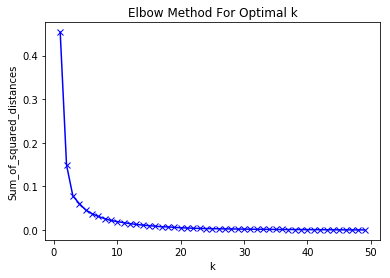

In [9]:
# grouping ( cluster) of postal codes
data_clustered = pin_area_df[['Latitude','Longitude']]

# find optimum K
K = range(1,50)
sum_sqd_distances =[]

for k in K:
    km = KMeans(n_clusters=k).fit(data_clustered)
    sum_sqd_distances.append(km.inertia_)
    
#  plotting the sum squared error to identify optimum k
plt.plot(K, sum_sqd_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

As we can see the optimum K in somewhere in between 10 and 20.Considering the vast spread city lets have 20 clusters
let's cluster the city with k= 20

In [10]:
# from the above graph we can see that optimal value of k is btw 10 n 20
# considering the vast spread city lets have 20 clusters
# clustering the city k= 20
k = 20

#lets build KMeans for 20 clusters
kmeans = KMeans(n_clusters =k).fit(data_clustered)

#add the cluster numbers to the dataframe
pin_area_df['clusters'] = kmeans.labels_

# store the labels and cluster centres
kmeans.labels = kmeans.labels_
kmeans_cluster_centers = kmeans.cluster_centers_

#print the shape of df and df
print("shape:", pin_area_df.shape)
pin_area_df.head()

shape: (89, 7)


,Area_name,PinCode,Latitude,Longitude,IsHospital,Hospital_list,clusters
0,Agripada,400011,18.975302,72.824898,1,"[Wockhardt Hospital, Nair Hospital, B Y L Nair...",7
1,Airport,400099,19.090201,72.863808,0,[],18
2,Ambewadi,400004,19.186776,72.859313,1,[st marys hospital],8
3,Andheri East,400069,19.115883,72.854202,1,[criticare hospital],3
4,Andheri H.o,400053,19.119125,72.847331,1,"[Sanjeevani Hospital, BSES Hospital, Brahmakum...",3


Let's have alook at the mumbai city with our clusters

In [11]:
# Let's create a folium map of Mumbai with the new clusters

# The lat longs for Mumbai are - 
M_lat = 19.0760
M_lng = 72.8777

# create a folium map of mumbai
Mumbai_map = folium.Map(location = [M_lat, M_lng], zoom_start=12)

# color format for clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# adding circle markers to all the pincodes, color acording to the clusters
for lat, lng, label, cluster in zip(pin_area_df.Latitude,pin_area_df.Longitude,pin_area_df.Area_name,pin_area_df.clusters):
    folium.features.CircleMarker(
        [lat,lng],
        radius = 5,
        color=rainbow[cluster-1],
        fill=True,
        popup=label,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.6
    ).add_to(Mumbai_map)

# display the map
Mumbai_map 

Extract a subset of the dataframe with all the pincodes that does not have hospitals. For these pincodes, we need to find a hospital in the cluster.

In [12]:
# lets see how many pincodes does not have a hospital
no_hospital_df = pin_area_df[pin_area_df['IsHospital']!= 1]

#Lets look at the dataframe
no_hospital_df

,Area_name,PinCode,Latitude,Longitude,IsHospital,Hospital_list,clusters
1,Airport,400099,19.090201,72.863808,0,[],18
8,Azad Nagar,400053,19.165798,72.955893,0,[],4
9,B P T Colony,400037,19.101937,72.861599,0,[],18
25,Colaba,400005,18.915091,72.825969,0,[],16
28,Danda,400052,19.076798,72.823893,0,[],9
35,Gokhale Road,400028,19.006304,72.830884,0,[],11
41,International Airport,400099,19.090201,72.863808,0,[],18
42,Irla,400056,18.902334,72.827427,0,[],16
48,Khar Colony,400052,19.116016,72.820022,0,[],0
53,Madh,400061,19.137528,72.791886,0,[],14


List down all the unique cluster numbers of the pincodes where there is no hospital

In [13]:
# unique cluster names of the postal codes that does not have hospitals
pd.unique(no_hospital_df["clusters"])

array([18,  4, 16,  9, 11,  0, 14,  1,  5, 13, 15])

To find all the hospitals in the cluster, lets create a dictionary of the clusters and all hospitals in that clusters

In [14]:
# lets create a dictionary of the clusters and all hospitals in that clusters
length = len(pd.unique(no_hospital_df["clusters"]))
Cluster_Hospital_dict = dict(zip(pd.unique(no_hospital_df["clusters"]),[np.nan for x in range(length)]))

#Lets look at the dictionary
print(Cluster_Hospital_dict)

{16: nan, 0: nan, 18: nan, 4: nan, 5: nan, 1: nan, 9: nan, 11: nan, 13: nan, 14: nan, 15: nan}


Adding two columns, to indicate if there is a hospital in the cluster and if there is, the list of all hospitals in the cluster. 

In [15]:
# lets copy the dataframe to another dataframe and continue processing
# This copy is useful so that we dont use many calls for the foursquare
continue_df = pin_area_df

# add two new columns that indicate if there is a hospital in the cluster 
# In a situation when there is no hospital in the radius, the hospital in the cluster will be used
continue_df["cluster_Is_H"] = 0
continue_df["cluster_H_list"] = pd.np.empty((len(continue_df), 0)).tolist()

#Lets look at the dataframe
continue_df.head()

,Area_name,PinCode,Latitude,Longitude,IsHospital,Hospital_list,clusters,cluster_Is_H,cluster_H_list
0,Agripada,400011,18.975302,72.824898,1,"[Wockhardt Hospital, Nair Hospital, B Y L Nair...",7,0,[]
1,Airport,400099,19.090201,72.863808,0,[],18,0,[]
2,Ambewadi,400004,19.186776,72.859313,1,[st marys hospital],8,0,[]
3,Andheri East,400069,19.115883,72.854202,1,[criticare hospital],3,0,[]
4,Andheri H.o,400053,19.119125,72.847331,1,"[Sanjeevani Hospital, BSES Hospital, Brahmakum...",3,0,[]


Create a dictionary, with the cluste number as the key and all the hospitals in that cluster as the Values.

In [16]:
# add all the hospitals in the cluster as the 'value' for 'key'(cluster number) in the dictionary
for k in Cluster_Hospital_dict:
    h_list = []
    for index, row in continue_df.iterrows():
        if k == row['clusters']:
            h_list.append(row['Hospital_list'])
# flattening list of lists to list
    Cluster_Hospital_dict[k] = list(set(itertools.chain(*h_list)))

Lets have a look at the dictionary

In [17]:
#Lets look at the dictionary
empty = []
for k,v in Cluster_Hospital_dict.items():
    if len(v) == 0:
        empty.append(k)
    print("%2d : %s"%(k,v))

16 : ['Ashwini Hospital Colaba']
 0 : ['Arogyanidhi hospital', 'Lotus Eye Hospital, Juhu', 'Lotus Eye Hospital', 'Arogya Nidhi Hospital', 'Bharatiya Arogya Nidhi Hospital', 'Lotus hospital', 'Cooper Hospital']
18 : ['Medicare hospital', "Kalpataru's Hospitality"]
 4 : []
 5 : ['Seaman Hospital', 'Banfield The Pet Hospital', 'Cama & Albless Hospital', 'St. George Hospital', 'St. George Hospital/college', 'Bombay Hospital New wing', 'Medi Heights Hospital, Irla, Vile Parle', 'Bombay Hospital & Medical Research Centre']
 1 : ['Dholkawala Maternity Hospital', 'Shaboo Siddiuqe Hospital', 'Habib Hospital', 'G.T.Hospital ( Chief translator and Interpreter HC dept)', 'Kothari Hospital', 'Bombay Hospital', 'Noor Hospital']
 9 : ['Noble Medicals Asha Parekh Hospital', 'Nanavati hospital', 'Sona Hospital', 'Santacruz Municipal General Hospital', 'Dish Hospitality', "Dr. Raut's Women's Hospital", 'R K Hospital', 'Shastri hospital']
11 : ['Gokhale Eye Hospital', 'Tata Memorial Hospital', 'gandhi ho

As can be seen, there are some clusters with no hospitals. We need to tag them accordingly. Let's add one columns which indicate whether there is a hospital in the cluster and another column with the list of hospitals in that cluster. 
For scenario, where in there is no hospital even in the cluster, lets just update the column values as "No Hospital Present".

In [18]:
print('The cluster with no hospital is :', empty)

The cluster with no hospital is : [4, 13, 14]


In [19]:
# as we can see from the dictionary some clusters does not have any hospitals in it, rest all have atleast a hospital in the cluster
# marking the IsHospital column accordingly
continue_df.loc[continue_df['IsHospital'] == 0, 'cluster_Is_H'] = 1
for i in empty:
    continue_df.loc[((continue_df['IsHospital'] == 0) & (continue_df['clusters'] == i)), 'cluster_Is_H'] = "No Hospital Present"
continue_df.head(20)

,Area_name,PinCode,Latitude,Longitude,IsHospital,Hospital_list,clusters,cluster_Is_H,cluster_H_list
0,Agripada,400011,18.975302,72.824898,1,"[Wockhardt Hospital, Nair Hospital, B Y L Nair...",7,0,[]
1,Airport,400099,19.090201,72.863808,0,[],18,1,[]
2,Ambewadi,400004,19.186776,72.859313,1,[st marys hospital],8,0,[]
3,Andheri East,400069,19.115883,72.854202,1,[criticare hospital],3,0,[]
4,Andheri H.o,400053,19.119125,72.847331,1,"[Sanjeevani Hospital, BSES Hospital, Brahmakum...",3,0,[]
5,Andheri Railway Station,400058,19.120371,72.848043,1,"[Sanjeevani Hospital, BSES Hospital, Brahmakum...",3,0,[]
6,Antop Hill,400037,19.020761,72.865256,1,[sai hospital],19,0,[]
7,Asvini,400005,18.900867,72.815941,1,[Ashwini Hospital Colaba],16,0,[]
8,Azad Nagar,400053,19.165798,72.955893,0,[],4,No Hospital Present,[]
9,B P T Colony,400037,19.101937,72.861599,0,[],18,1,[]


Assign the first hospital in the list of "Hospital_list" column to the "cluster_H_list" column(for ease of processing), for the scenarios where there is a hospital in the cluster.

In [20]:
# putting the first hospital from the list of hospitals(clusters) to the pincode
for k in Cluster_Hospital_dict:
    try :
        continue_df.loc[((continue_df['IsHospital'] == 0) & (continue_df['clusters'] == k)),'cluster_H_list'] = Cluster_Hospital_dict[k][0]
    except :
        continue_df.loc[((continue_df['IsHospital'] == 0) & (continue_df['clusters'] == k)),'cluster_H_list'] = "No Hospital Present"

As a suggestion, lets pick 
1. The first hospital in the column "Hospital_list" - where there is a hospital in the pincode
2. The hosiptal in the colum "cluster_H_list" - where there is no hospital in the pincode, but there is a hospital in the cluster.
Lets put our suggesions into the column "Govt_Hospital"

In [21]:
continue_df['Govt_Hospital'] = np.where(continue_df['IsHospital'] == 1, continue_df['Hospital_list'].str[0], continue_df['cluster_H_list'])

In [22]:
continue_df.head()

,Area_name,PinCode,Latitude,Longitude,IsHospital,Hospital_list,clusters,cluster_Is_H,cluster_H_list,Govt_Hospital
0,Agripada,400011,18.975302,72.824898,1,"[Wockhardt Hospital, Nair Hospital, B Y L Nair...",7,0,[],Wockhardt Hospital
1,Airport,400099,19.090201,72.863808,0,[],18,1,Medicare hospital,Medicare hospital
2,Ambewadi,400004,19.186776,72.859313,1,[st marys hospital],8,0,[],st marys hospital
3,Andheri East,400069,19.115883,72.854202,1,[criticare hospital],3,0,[],criticare hospital
4,Andheri H.o,400053,19.119125,72.847331,1,"[Sanjeevani Hospital, BSES Hospital, Brahmakum...",3,0,[],Sanjeevani Hospital


THE END!!!